# variance reduction techniques

## Creating and utilising a wight window to accelerate the deep shielding simulations

This example implements a single step of the Magic method of weight window generation. The theory of weight windows and the method are best described by the paper here https://scientific-publications.ukaea.uk/wp-content/uploads/Published/INTERN1.pdf

In this tutorial we shall focus on generating a weight window to accelerate the simulation of particles through a shield.

First we must make a model. This is kept as simple as possible as the focus of this notebook is on generating and then using a weight window.

The model is a single sphere of 200 cm radius filled with water and containing a 14MeV point source in the center

In [2]:
import openmc

# creates a shielding material
water = openmc.Material(name='Water')
water.set_density('g/cc', 1.0)
water.add_element('H', 2)
water.add_element('O', 1)
materials = openmc.Materials([water])

sphere1 = openmc.Sphere(r=200, boundary_type='vacuum')

region1 = -sphere1

cell1 = openmc.Cell(fill=water, region=region1)

geometry = openmc.Geometry([cell1])

source = openmc.Source()
source.space = openmc.stats.Point((0.0, 0.0, 0.0))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([14e6], [1.0])
source.particle = 'neutron'

my_settings = openmc.Settings()
my_settings.run_mode = 'fixed source'
my_settings.source = source
my_settings.particles = 10000
my_settings.batches = 10
# the mesh tallies produce large tallies.out files so this output setting avoids writing the tallies.out and saves time
my_settings.output = {'tallies': False}

model = openmc.model.Model(geometry, materials, my_settings)

Now we can plot the simple geometry

<Figure size 1000x1000 with 0 Axes>

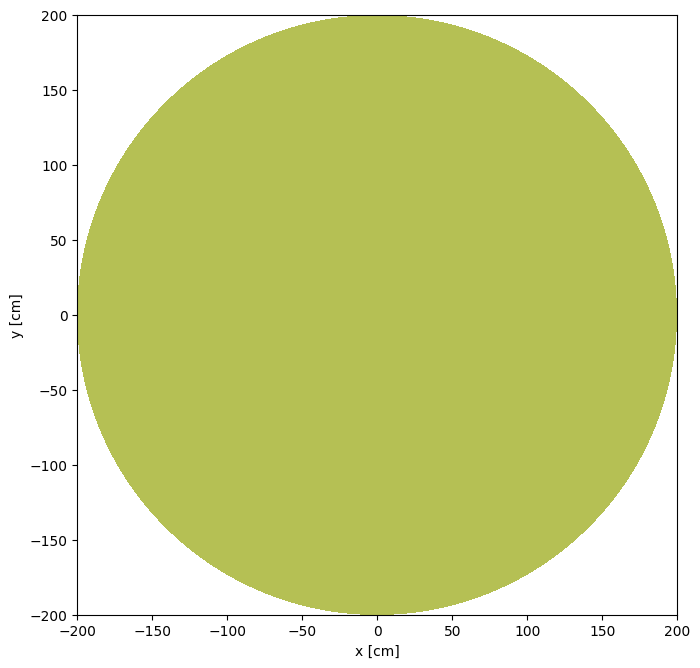

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
model.geometry.root_universe.plot(width=(400, 400), pixels=(600, 600))
plt.show()

Now we shall add a regular mesh tally over the the geometry.

The mesh will be used to record the neutron flux in each mesh voxel

In [4]:
mesh = openmc.RegularMesh()
mesh.lower_left = model.geometry.bounding_box[0]
mesh.upper_right = model.geometry.bounding_box[1]
mesh.dimension = (50, 50, 50)

mesh_filter = openmc.MeshFilter(mesh)

flux_tally_for_ww = openmc.Tally(name='flux tally')
flux_tally_for_ww.filters = [mesh_filter]
flux_tally_for_ww.scores = ['flux']

# adds the mesh tally to the model
model.tallies = [flux_tally_for_ww]

Now we shall run the simulation in analog mode

In [ ]:
output_file = model.run()


In [ ]:
with openmc.StatePoint(output_file) as sp:
    flux_tally_result = sp.get_tally(id=flux_tally_for_ww.id)
plt.imshow(flux_tally.mean)
plt.show()

Now we shall run the simulation and record flux in each mesh voxel

In [5]:
model.export_to_xml()
import openmc.lib

openmc.lib.init()

# gets a live pointer to the mesh tally that we use to generate the 
ww_tally = openmc.lib.tallies[flux_tally_for_ww.id]
# generates a weight window from the tally (which is currently empty)
wws = openmc.lib.WeightWindows.from_tally(ww_tally)

# runs the simulation
openmc.lib.run()

# turn the weight windows on
openmc.lib.settings.weight_windows_on = True

# updates the weight window with the latest mesh tally flux results 
# As this flux map tells us where the neutrons go we can use it to create a wight window that promotes neutron transport in areas they normally don't reach.
wws.update_magic(ww_tally)

# runs the simulation
openmc.lib.run()

openmc.lib.simulation_finalize()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now we can plot the flux and the standard deviation of the flux tally to see how far into the shield the neutrons got. 

In [ ]:
from matplotlib.colors import LogNorm

with openmc.StatePoint(f'statepoint.{my_settings.batches}.h5') as sp:
    flux_tally_result = sp.get_tally(id=flux_tally_for_ww.id)


slice_index = int(mesh.dimension[-1]/2)

# create a plot of the mean values
flux_mean = flux_tally.mean.reshape(*mesh.dimension)
img1 = ax1.imshow(flux_mean[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]), norm=LogNorm())
ax1.set_title('Flux Mean')
plt.colorbar(img1, ax=ax1, fraction=0.046)
img1.set_clim(vmin=1e-30, vmax=1.0)

# create a plot of the flux relative error
flux_rel_err = flux_tally.get_values(value='rel_err').reshape(*mesh.dimension)
img2 = ax2.imshow(flux_rel_err[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]))
ax2.set_title('Flux Rel. Err.')
plt.colorbar(img2, ax=ax2, fraction=0.046)
# ax2.set_colorbar(img2, ax=ax2)
img2.set_clim(vmin=0.0, vmax=1.0)

plt.show()

The weight window generated uses the same mesh as the flux tally, uses the flux to generate lower_ww_bounds, sets the upper_bound_ratio to 5 (rule of thumb used here) and sets the max_split to 1_000_000. These can all be changed to customise the weight window but are reasonable defaults.

We can plot the lower_ww_bounds of the generated weight window to see how it changes over the geometry

In [ ]:
plt.imshow(weight_windows[0].lower_ww_bounds[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]), norm=LogNorm())
plt.title('lower_ww_bounds')
plt.colorbar()

Now we can rerun the simulation but this time using the weight window to push the particles further into the geometry

In [ ]:
#deletes the old output files
!rm summary.h5
!rm statepoint.*.h5


model.settings.weight_windows = weight_windows
model.settings.max_split = 1_000 # might want to increase this to 1_000_000 and get a better result 
model.run()

We can now plot the flux and standard devation of the flux for the simulation that used weight windows and see that the particles penetrated further into the shield and that the standard deviation has been reduced.

In [ ]:
with openmc.StatePoint(output_file) as sp:
    flux_tally = sp.get_tally(id=flux_tally.id)

fig,  (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout() 
fig.suptitle('Flux and std. dev. with weight window')

# create a plot of the mean values
flux_mean = flux_tally.mean.reshape(*mesh.dimension)
img1 = ax1.imshow(flux_mean[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]), norm=LogNorm())
ax1.set_title('Flux Mean')
plt.colorbar(img1, ax=ax1, fraction=0.046)
img1.set_clim(vmin=1e-30, vmax=1.0)

# create a plot of the flux relative error
flux_rel_err = flux_tally.get_values(value='rel_err').reshape(*mesh.dimension)
img2 = ax2.imshow(flux_rel_err[slice_index], origin='lower', extent=(llc[0], urc[0], llc[1], urc[1]))
ax2.set_title('Flux Rel. Err.')
plt.colorbar(img2, ax=ax2, fraction=0.046)
# ax2.set_colorbar(img2, ax=ax2)
img2.set_clim(vmin=0.0, vmax=1.0)

plt.show()

Notice that the particles now get further into the shielding and the error has been reduce across the simulation.

This is not exactly a fair comparison as the second simulation takes a little longer to run. To make it fairer we could use a trigger to stop each simulation after the same amount of time. However that would complicate the example.

Learning Outcomes:
* Weight windows can be useful for accelerating deep shielding simulations where particles
* Weight windows can be generated from a neutron flux field
* The MAGIC method is a popular method of generating weight windows